In [156]:
from collections import OrderedDict

import torch.nn.functional as F
import torch
from torch import nn
from torch.nn.utils import spectral_norm
import random
from algorithms.Transformer import Transformer

usage: ipykernel_launcher.py [-h] [--device DEVICE]
                             [--num_workers NUM_WORKERS]
                             [--save_every SAVE_EVERY] [--verbose VERBOSE]
                             [--seed SEED] [--iid IID] --alg
                             {fedavg,fedprox,moon,scaffold} --dataset
                             {smd,smap,psm} --tsadalg
                             {gdn,deep_svdd,usad,tran_ad,lstm_ae}
                             [--num_clients NUM_CLIENTS]
                             [--slide_win SLIDE_WIN]
                             [--client_rate CLIENT_RATE] [--beta BETA]
ipykernel_launcher.py: error: the following arguments are required: --alg, --dataset, --tsadalg


SystemExit: 2

D:\Software\Anaconda3\envs\Pytorch\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [106]:
class ViTHyper(nn.Module):

    def __init__(self, n_nodes, embedding_dim, hidden_dim, dim, client_sample, heads=8, dim_head=16, n_hidden=1, depth=6,
                 spec_norm=False):
        super(ViTHyper, self).__init__()
        self.dim = dim
        self.inner_dim = dim_head * heads
        self.depth = depth
        self.client_sample = client_sample
        # embedding layer
        self.embeddings = nn.Embedding(num_embeddings=n_nodes, embedding_dim=embedding_dim)

        layers = [
            spectral_norm(nn.Linear(embedding_dim, hidden_dim)) if spec_norm else nn.Linear(embedding_dim, hidden_dim),
        ]
        for _ in range(n_hidden):
            layers.append(nn.ReLU(inplace=True))
            layers.append(
                spectral_norm(nn.Linear(hidden_dim, hidden_dim)) if spec_norm else nn.Linear(hidden_dim, hidden_dim),
            )

        self.mlp = nn.Sequential(*layers)

        self.to_qkv_value_list=nn.ModuleList([])
        for d in range(self.depth):
            to_qkv_value = nn.Linear(hidden_dim, self.dim * self.inner_dim)
            self.to_qkv_value_list.append(to_qkv_value)


    def finetune(self, emd):
        features = self.mlp(emd)
        weights=OrderedDict()
        for d in range(self.depth):
            layer_d_qkv_value_hyper = self.to_qkv_value_list[d]
            layer_d_qkv_value = layer_d_qkv_value_hyper(features).view(self.inner_dim,self.dim)
            weights["transformer.layers."+str(d)+".0.fn.to_qkv.weight"]=layer_d_qkv_value
        return weights


    def forward(self, idx, test):
        weights = 0
        emd = self.embeddings(idx)
        print(emd.shape)
        features = self.mlp(emd)
        print(features.shape)
        if test == False:
            weights = [OrderedDict()  for x in range(self.client_sample)]
            for d in range(self.depth):
                layer_d_qkv_value_hyper = self.to_qkv_value_list[d]
                layer_d_qkv_value = layer_d_qkv_value_hyper(features).view(-1,self.inner_dim,self.dim)
                for nn in range(self.client_sample):
                    weights[nn]["transformer.layers."+str(d)+".0.fn.to_qkv.weight"]=layer_d_qkv_value[nn]
        else:
            weights=OrderedDict()
            for d in range(self.depth):
                layer_d_qkv_value_hyper = self.to_qkv_value_list[d]
                layer_d_qkv_value = layer_d_qkv_value_hyper(features).view(self.inner_dim,self.dim)
                weights["transformer.layers."+str(d)+".0.fn.to_qkv.weight"]=layer_d_qkv_value
        return weights

class CNNHyper(nn.Module):
    def __init__(
            self, n_nodes, embedding_dim, in_channels=3, out_dim=10, n_kernels=16, hidden_dim=100,
            spec_norm=False, n_hidden=1):
        super().__init__()

        self.in_channels = in_channels
        self.out_dim = out_dim
        self.n_kernels = n_kernels
        self.embeddings = nn.Embedding(num_embeddings=n_nodes, embedding_dim=embedding_dim)

        layers = [
            spectral_norm(nn.Linear(embedding_dim, hidden_dim)) if spec_norm else nn.Linear(embedding_dim, hidden_dim),
        ]
        for _ in range(n_hidden):
            layers.append(nn.ReLU(inplace=True))
            layers.append(
                spectral_norm(nn.Linear(hidden_dim, hidden_dim)) if spec_norm else nn.Linear(hidden_dim, hidden_dim),
            )

        self.mlp = nn.Sequential(*layers)

        self.c1_weights = nn.Linear(hidden_dim, self.n_kernels * self.in_channels * 5 * 5)
        self.c1_bias = nn.Linear(hidden_dim, self.n_kernels)
        self.c2_weights = nn.Linear(hidden_dim, 2 * self.n_kernels * self.n_kernels * 5 * 5)
        self.c2_bias = nn.Linear(hidden_dim, 2 * self.n_kernels)
        self.l1_weights = nn.Linear(hidden_dim, 120 * 2 * self.n_kernels * 5 * 5)
        self.l1_bias = nn.Linear(hidden_dim, 120)
        self.l2_weights = nn.Linear(hidden_dim, 84 * 120)
        self.l2_bias = nn.Linear(hidden_dim, 84)
        self.l3_weights = nn.Linear(hidden_dim, self.out_dim * 84)
        self.l3_bias = nn.Linear(hidden_dim, self.out_dim)

        if spec_norm:
            self.c1_weights = spectral_norm(self.c1_weights)
            self.c1_bias = spectral_norm(self.c1_bias)
            self.c2_weights = spectral_norm(self.c2_weights)
            self.c2_bias = spectral_norm(self.c2_bias)
            self.l1_weights = spectral_norm(self.l1_weights)
            self.l1_bias = spectral_norm(self.l1_bias)
            self.l2_weights = spectral_norm(self.l2_weights)
            self.l2_bias = spectral_norm(self.l2_bias)
            self.l3_weights = spectral_norm(self.l3_weights)
            self.l3_bias = spectral_norm(self.l3_bias)

    def forward(self, idx):
        emd = self.embeddings(idx)
        features = self.mlp(emd)

        weights = OrderedDict({
            "conv1.weight": self.c1_weights(features).view(self.n_kernels, self.in_channels, 5, 5),
            "conv1.bias": self.c1_bias(features).view(-1),
            "conv2.weight": self.c2_weights(features).view(2 * self.n_kernels, self.n_kernels, 5, 5),
            "conv2.bias": self.c2_bias(features).view(-1),
            "fc1.weight": self.l1_weights(features).view(120, 2 * self.n_kernels * 5 * 5),
            "fc1.bias": self.l1_bias(features).view(-1),
            "fc2.weight": self.l2_weights(features).view(84, 120),
            "fc2.bias": self.l2_bias(features).view(-1),
            "fc3.weight": self.l3_weights(features).view(self.out_dim, 84),
            "fc3.bias": self.l3_bias(features).view(-1),
        })
        return weights

class CNNTarget(nn.Module):
    def __init__(self, in_channels=3, n_kernels=16, out_dim=10):
        super(CNNTarget, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, n_kernels, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n_kernels, 2 * n_kernels, 5)
        self.fc1 = nn.Linear(2 * n_kernels * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [96]:
hnet = ViTHyper(n_nodes=50, embedding_dim=10, hidden_dim=128, dim=1, client_sample=1, depth=3)
tran = Transformer(enc_in=33, c_out=33)
input = torch.rand((128, 12, 33))
output, attns = tran(input)
# print(hnet, tran)
for param_tensor in hnet.state_dict():
    print(param_tensor, "\t", hnet.state_dict()[param_tensor].size())

embeddings.weight 	 torch.Size([50, 10])
mlp.0.weight 	 torch.Size([128, 10])
mlp.0.bias 	 torch.Size([128])
mlp.2.weight 	 torch.Size([128, 128])
mlp.2.bias 	 torch.Size([128])
to_qkv_value_list.0.weight 	 torch.Size([128, 128])
to_qkv_value_list.0.bias 	 torch.Size([128])
to_qkv_value_list.1.weight 	 torch.Size([128, 128])
to_qkv_value_list.1.bias 	 torch.Size([128])
to_qkv_value_list.2.weight 	 torch.Size([128, 128])
to_qkv_value_list.2.bias 	 torch.Size([128])


In [148]:
for param_tensor in tran.state_dict():
    print(param_tensor, "\t", tran.state_dict()[param_tensor].size())

enc_embedding.value_embedding.tokenConv.weight 	 torch.Size([128, 33, 3])
enc_embedding.position_embedding.pe 	 torch.Size([1, 5000, 128])
enc_embedding.temporal_embedding.hour_embed.emb.weight 	 torch.Size([24, 128])
enc_embedding.temporal_embedding.weekday_embed.emb.weight 	 torch.Size([7, 128])
enc_embedding.temporal_embedding.day_embed.emb.weight 	 torch.Size([32, 128])
enc_embedding.temporal_embedding.month_embed.emb.weight 	 torch.Size([13, 128])
encoder.attn_layers.0.attention.query_projection.weight 	 torch.Size([128, 128])
encoder.attn_layers.0.attention.query_projection.bias 	 torch.Size([128])
encoder.attn_layers.0.attention.key_projection.weight 	 torch.Size([128, 128])
encoder.attn_layers.0.attention.key_projection.bias 	 torch.Size([128])
encoder.attn_layers.0.attention.value_projection.weight 	 torch.Size([128, 128])
encoder.attn_layers.0.attention.value_projection.bias 	 torch.Size([128])
encoder.attn_layers.0.attention.out_projection.weight 	 torch.Size([128, 128])
enc

In [105]:
node_id = random.choice(range(50))
print(node_id)
weights = hnet(torch.tensor([node_id], dtype=torch.long),False)
# weights['transformer.layers.0.0.fn.to_qkv.weight'].shape
tran.load_state_dict(weights[0],strict=False)

6
torch.Size([1, 10])
torch.Size([1, 128])


_IncompatibleKeys(missing_keys=['enc_embedding.value_embedding.tokenConv.weight', 'enc_embedding.position_embedding.pe', 'enc_embedding.temporal_embedding.hour_embed.emb.weight', 'enc_embedding.temporal_embedding.weekday_embed.emb.weight', 'enc_embedding.temporal_embedding.day_embed.emb.weight', 'enc_embedding.temporal_embedding.month_embed.emb.weight', 'encoder.attn_layers.0.attention.query_projection.weight', 'encoder.attn_layers.0.attention.query_projection.bias', 'encoder.attn_layers.0.attention.key_projection.weight', 'encoder.attn_layers.0.attention.key_projection.bias', 'encoder.attn_layers.0.attention.value_projection.weight', 'encoder.attn_layers.0.attention.value_projection.bias', 'encoder.attn_layers.0.attention.out_projection.weight', 'encoder.attn_layers.0.attention.out_projection.bias', 'encoder.attn_layers.0.conv1.weight', 'encoder.attn_layers.0.conv1.bias', 'encoder.attn_layers.0.conv2.weight', 'encoder.attn_layers.0.conv2.bias', 'encoder.attn_layers.0.norm1.weight', 'e

In [95]:
for param_tensor in tran.state_dict():
    print(param_tensor, "\t", tran.state_dict()[param_tensor].size())

enc_embedding.value_embedding.tokenConv.weight 	 torch.Size([128, 33, 3])
enc_embedding.position_embedding.pe 	 torch.Size([1, 5000, 128])
enc_embedding.temporal_embedding.hour_embed.emb.weight 	 torch.Size([24, 128])
enc_embedding.temporal_embedding.weekday_embed.emb.weight 	 torch.Size([7, 128])
enc_embedding.temporal_embedding.day_embed.emb.weight 	 torch.Size([32, 128])
enc_embedding.temporal_embedding.month_embed.emb.weight 	 torch.Size([13, 128])
encoder.attn_layers.0.attention.query_projection.weight 	 torch.Size([128, 128])
encoder.attn_layers.0.attention.query_projection.bias 	 torch.Size([128])
encoder.attn_layers.0.attention.key_projection.weight 	 torch.Size([128, 128])
encoder.attn_layers.0.attention.key_projection.bias 	 torch.Size([128])
encoder.attn_layers.0.attention.value_projection.weight 	 torch.Size([128, 128])
encoder.attn_layers.0.attention.value_projection.bias 	 torch.Size([128])
encoder.attn_layers.0.attention.out_projection.weight 	 torch.Size([128, 128])
enc

In [123]:
net = CNNTarget()
node_id = random.choice(range(50))
print(node_id)
hnet = CNNHyper(n_nodes = 50, embedding_dim = 32, in_channels=3, out_dim=10, n_kernels=16, hidden_dim=100,
        spec_norm=False, n_hidden=1)
weights = hnet(torch.tensor([node_id], dtype=torch.long))
# weights

36


In [125]:
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

conv1.weight 	 torch.Size([16, 3, 5, 5])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 5, 5])
conv2.bias 	 torch.Size([32])
fc1.weight 	 torch.Size([120, 800])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])


In [137]:
net.load_state_dict(weights)
weights

OrderedDict([('conv1.weight',
              tensor([[[[-3.9400e-01, -1.7225e-03, -6.1360e-02,  8.4005e-02, -1.6359e-01],
                        [-1.3222e-01,  8.2973e-02,  2.8054e-01, -3.3338e-02,  4.8643e-02],
                        [-1.0127e-01,  1.1312e-01, -7.3606e-02,  2.7939e-01,  1.0244e-01],
                        [-7.3823e-02,  5.8411e-02, -6.5767e-03, -1.9918e-01,  7.3714e-02],
                        [ 2.5907e-01, -2.4011e-02,  8.8819e-02,  2.4550e-02, -3.3810e-01]],
              
                       [[-2.4813e-01,  3.7920e-02, -1.0023e-01,  7.2113e-02,  1.7809e-01],
                        [ 1.0871e-01,  1.5067e-02,  5.0313e-02, -3.4471e-01, -3.3261e-02],
                        [-3.6178e-03, -8.9375e-02, -3.6598e-02, -7.8733e-02, -3.6396e-02],
                        [ 1.3598e-01,  1.6788e-01,  1.3791e-01, -2.7951e-01,  2.7573e-01],
                        [ 4.2601e-02, -8.3858e-02, -3.5726e-02,  1.0721e-01, -9.8043e-02]],
              
                       [[-1.

In [136]:
net_stat = tran.state_dict()
net_stat['encoder.attn_layers.2.attention.out_projection.weight'].shape

torch.Size([128, 128])

In [149]:
hnet = ViTHyper(n_nodes=50, embedding_dim=10, hidden_dim=128, dim=128, client_sample=1, depth=3)
tran = Transformer(enc_in=33, c_out=33)
input = torch.rand((128, 12, 33))
output, attns = tran(input)
weights = hnet(torch.tensor([node_id], dtype=torch.long),False)
weights[0]['transformer.layers.0.0.fn.to_qkv.weight']
# print(hnet, tran)
# for param_tensor in hnet.state_dict():
#     print(param_tensor, "\t", hnet.state_dict()[param_tensor].size())


torch.Size([1, 10])
torch.Size([1, 128])


tensor([[ 0.1520, -0.0317, -0.2242,  ..., -0.0435,  0.0419, -0.1446],
        [ 0.1454, -0.0201, -0.0644,  ...,  0.0057,  0.0147, -0.1237],
        [-0.1787,  0.1632, -0.0003,  ...,  0.0698,  0.0187, -0.1029],
        ...,
        [ 0.0246, -0.0194,  0.0339,  ..., -0.0164, -0.0685,  0.0913],
        [-0.0593,  0.1192,  0.0149,  ...,  0.0051, -0.2329, -0.0383],
        [-0.0648, -0.0676,  0.0345,  ..., -0.0263,  0.0120,  0.0586]],
       grad_fn=<SelectBackward0>)

In [154]:
tranformer_stat = tran.state_dict()
tranformer_stat['encoder.attn_layers.0.attention.query_projection.weight'] = weights[0]['transformer.layers.0.0.fn.to_qkv.weight']
tran.load_state_dict(tranformer_stat)

<All keys matched successfully>

In [155]:
X_train, y_train, X_test, y_test, net_dataidx_map, traindata_cls_counts = partition_data(
        dataset = 'psm',
        datadir = "../data",
        partition = "noniid",
        n_parties = 10
    )

NameError: name 'partition_data' is not defined

In [1]:
import matplotlib as mpl
print(mpl.get_cachedir())

C:\Users\Hjf\.matplotlib


Text(0.5, 1.0, 'hjf')

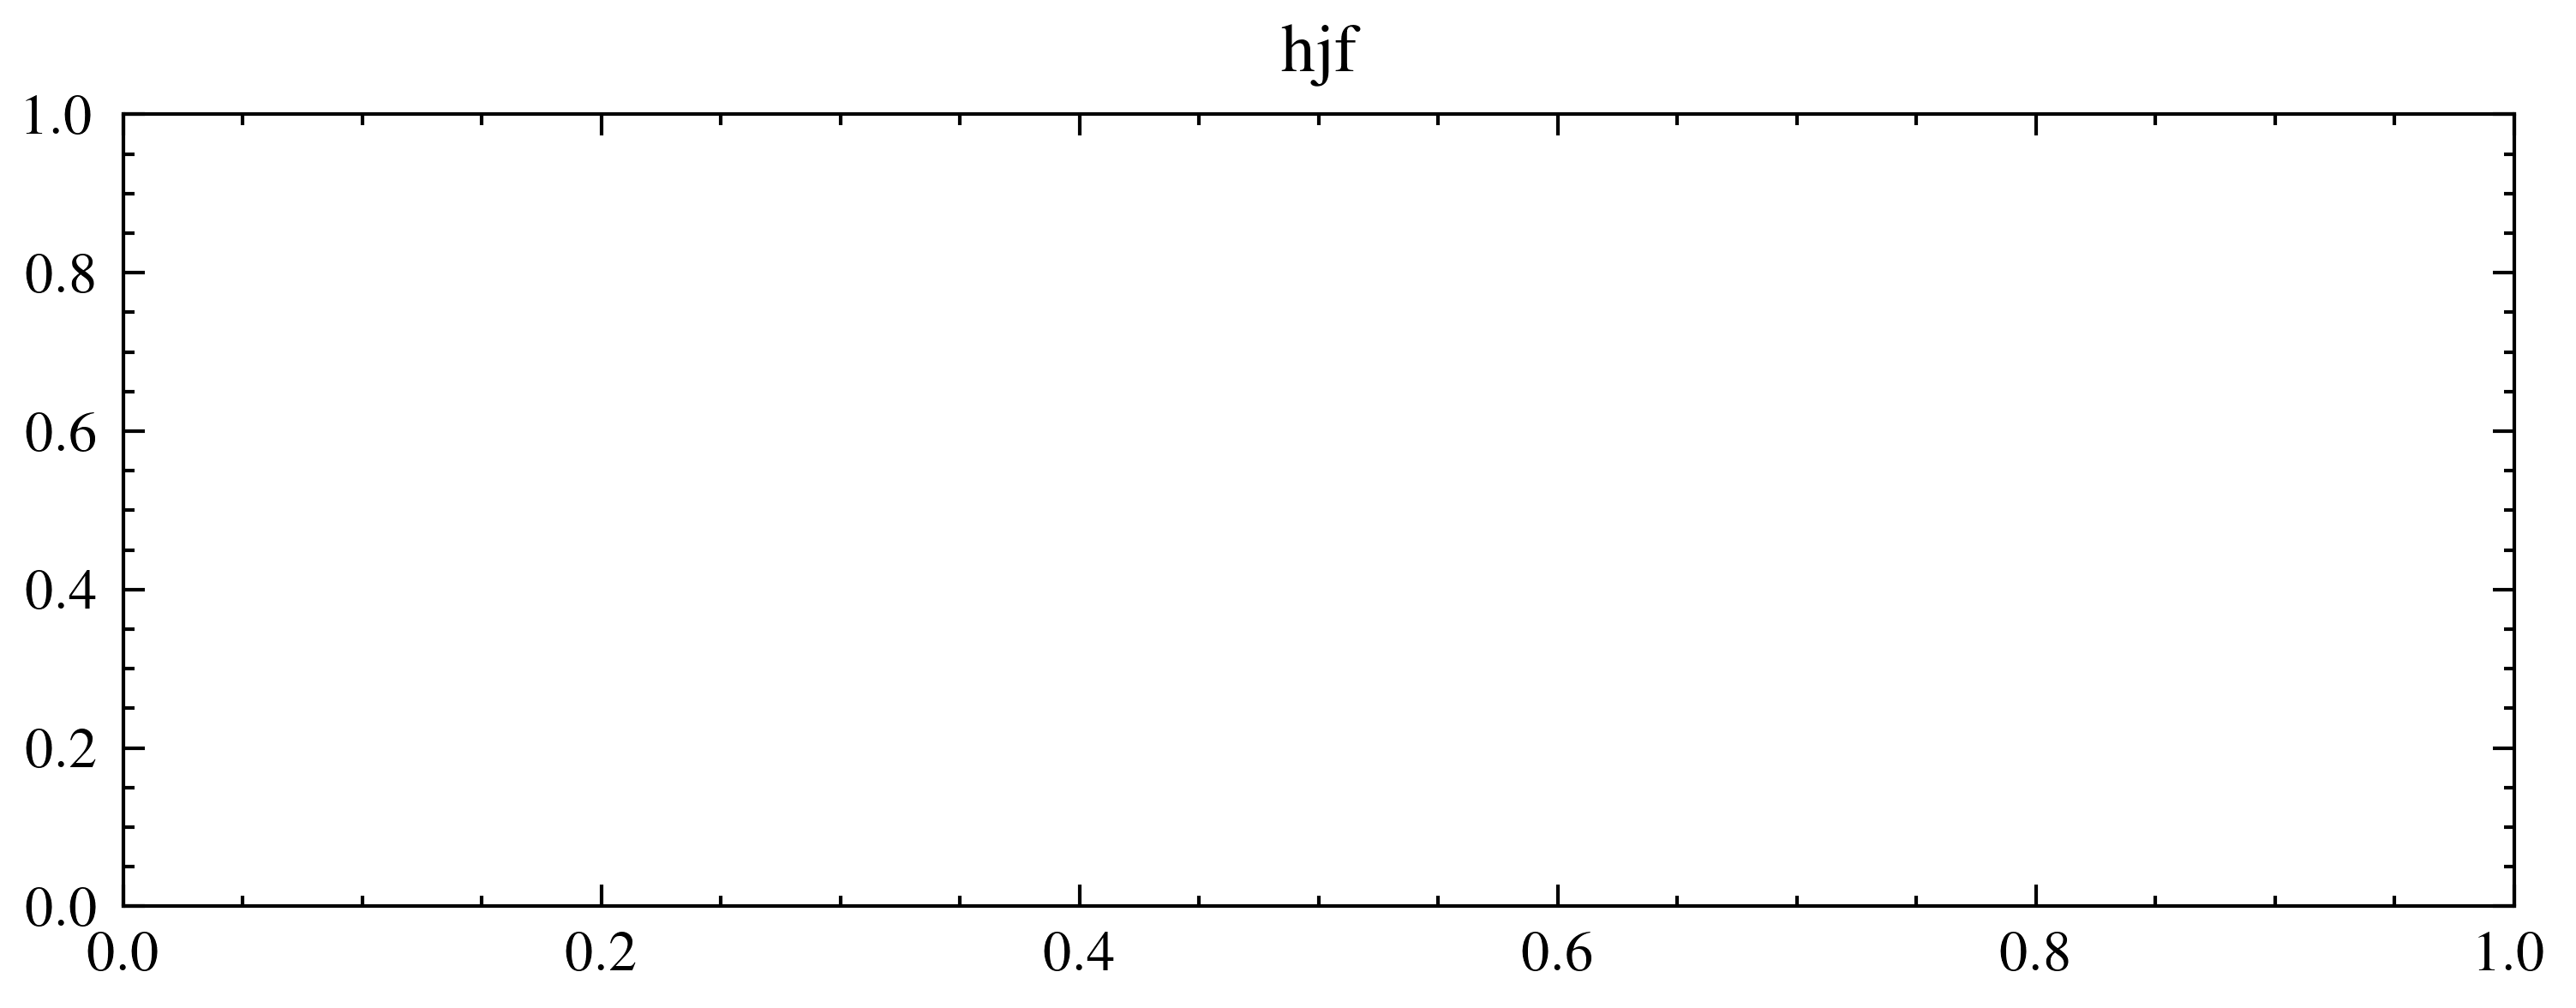

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.style.use(['science', 'ieee'])
# plt.rcParams["text.usetex"] = False
plt.rcParams['figure.figsize'] = 6, 2
plt.figure()
plt.title("hjf")

In [5]:
import matplotlib
from matplotlib import font_manager

font_list=sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
for i in font_list:
    print(i)

Arial
Arial
Arial
Arial
Arial
Bahnschrift
Calibri
Calibri
Calibri
Calibri
Calibri
Calibri
Cambria
Cambria
Cambria
Cambria
Candara
Candara
Candara
Candara
Candara
Candara
Comic Sans MS
Comic Sans MS
Comic Sans MS
Comic Sans MS
Consolas
Consolas
Consolas
Consolas
Constantia
Constantia
Constantia
Constantia
Corbel
Corbel
Corbel
Corbel
Corbel
Corbel
Courier New
Courier New
Courier New
Courier New
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans Display
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif Display
DengXian
DengXian
DengXian
Ebrima
Ebrima
FangSong
Franklin Gothic Medium
Franklin Gothic Medium
Gabriola
Gadugi
Gadugi
Georgia
Georgia
Georgia
Georgia
HoloLens MDL2 Assets
Impact
Ink Free
Javanese Text
KaiTi
Leelawadee UI
Leelawadee UI
Leelawadee UI
Lucida Console
Lucida Sans Unicode
MS Gothic
MV Boli
Malgun Gothic
Malgun Gothic
Malgun Gothic
Marlett
Microsoft Himalaya
Microsoft JhengHei
Micr